In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from os import listdir
train_data_li = listdir('./train/')
train_data_li

import sys
mod = sys.modules[__name__]
for name in train_data_li:
    setattr(mod, name.split('.')[0], pd.read_csv('./train/' + name))
    
train_activity.shape, train_combat.shape, train_pledge.shape, train_trade.shape, train_payment.shape, train_label.shape

((1601834, 17),
 (1574671, 13),
 (1083384, 15),
 (1849325, 11),
 (66432, 3),
 (40000, 3))

((40000, 425), (40000,))

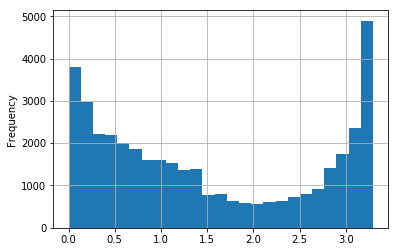

In [2]:
df = train_activity[
        [col for col in train_activity.columns if col not in ['server',  'char_id']]
    ].groupby(['day', 'acc_id']).sum().reset_index()

df_grouped = df.groupby('day')
p = df_grouped.get_group(1)
for i in range(2, 29):
    p = pd.merge(p, df_grouped.get_group(i), on='acc_id', how='outer',
                 suffixes=('_'+str(i-1), '_'+str(i)))
p = p[[col for col in p.columns if ('day' not in col) & ('char' not in col)]]
p = p.fillna(0).set_index('acc_id')

playtime_daily = train_activity.groupby(['acc_id', 'day'])['playtime'].sum().unstack().fillna(0)
exp_weights = np.sqrt(np.arange(1, 29)) / np.sqrt(np.arange(1, 29)).sum()
playtime_exp = playtime_daily * exp_weights
playtime_exp.sum(axis=1).plot.hist(bins=25, grid=True)

df = p.reset_index()
p2 = pd.DataFrame(playtime_exp.sum(axis=1), columns=['exp_playtime']).reset_index()
df = pd.merge(df, p2, on='acc_id')

d = pd.DataFrame(list(set([(i, j) for i,j in train_activity[['day', 'acc_id']].values])), columns=['day', 'acc_id'])
df = pd.merge(df, d.groupby('acc_id').count().reset_index(), on='acc_id')

train_act_time = train_activity[['acc_id', 'day', 'playtime', 'fishing', 'private_shop']]
train_act_time = train_act_time.groupby(['acc_id', 'day']).sum()
train_act_time['resttime'] = train_act_time['fishing'] + train_act_time['private_shop']
train_act_time['tr_play'] = (train_act_time['playtime'] - train_act_time['resttime']) / train_act_time['playtime']
train_act_time['tr_rest'] = train_act_time['resttime'] / train_act_time['playtime']
rest = train_act_time['tr_rest'].unstack().fillna(1)
play = train_act_time['tr_play'].unstack().fillna(0)

rest.columns = ['rest_'+str(i) for i in range(1, 29)]
play.columns = ['play_'+str(i) for i in range(1, 29)]

exp_weights = np.sqrt(np.arange(1, 29)) / np.sqrt(np.arange(1, 29)).sum()
rest['exp_rest'] = (rest * exp_weights).sum(axis=1)
play['exp_play'] = (play * exp_weights).sum(axis=1)

df = pd.merge(df, rest.reset_index(), on='acc_id')
df = pd.merge(df, play.reset_index(), on='acc_id')

label = np.where(train_label.set_index('acc_id').loc[p.index]['survival_time'].values == 64, 1, 0)

df.shape, label.shape

# Expected Return

In [3]:
sort_acc_id = p.index

is_churn_label = np.where(train_label.set_index('acc_id').loc[sort_acc_id]['survival_time'].values == 64, 1, 0)
amount_label = train_label.set_index('acc_id').loc[sort_acc_id]['amount_spent']
survtime_label = train_label.set_index('acc_id').loc[sort_acc_id]['survival_time']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], label, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((21000, 424), (7000, 424), (12000, 424), (21000,), (7000,), (12000,))

In [5]:
y_train1 = is_churn_label[X_train.index]
y_train1a = survtime_label.values[X_train.index]
y_train2 = amount_label.values[X_train.index]

y_valid1 = is_churn_label[X_valid.index]
y_valid1a = survtime_label.values[X_valid.index]
y_valid2 = amount_label.values[X_valid.index]

y_test1 = is_churn_label[X_test.index]
y_test1a = survtime_label.values[X_test.index]
y_test2 = amount_label.values[X_test.index]

In [6]:
import xgboost as xgb

params =   {
    'objective' : 'reg:linear',
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300
}

In [10]:
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train2)
    va_data = xgb.DMatrix(X_valid, y_valid2)

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    %time model2 = xgb.train(params, tr_data, 500, watchlist, maximize=False, early_stopping_rounds = 30, verbose_eval=50)

[0]	train-rmse:0.816628	valid-rmse:0.804051
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:0.579939	valid-rmse:0.724347
[100]	train-rmse:0.45623	valid-rmse:0.72948
Stopping. Best iteration:
[71]	train-rmse:0.520659	valid-rmse:0.7225

Wall time: 2min 5s


In [11]:
model2.save_model('model2.model')

In [13]:
y_pred = model2.predict(xgb.DMatrix(X_test))
y_pred

array([0.16520593, 0.1349616 , 0.16198963, ..., 1.5253782 , 0.19498032,
       0.1470868 ], dtype=float32)

In [14]:
np.sqrt(np.mean((y_test2 - y_pred) ** 2))

0.7218267636226796

In [15]:
model1 = xgb.Booster()
model1.load_model('0004-1.model')

In [18]:
y_pred = np.where(model1.predict(xgb.DMatrix(X_test)) > .5, 1, 0)
y_pred

array([1, 0, 1, ..., 0, 0, 0])

In [19]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_score(y_test1, y_pred), f1_score(y_test1, y_pred)

(0.7646666666666667, 0.7890017931858936)

In [7]:
params =   {
    'objective' : 'multi:softprob',
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'merror',
    'num_class' : 64,
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 300,
    'n_estimators': 200,
    'max_leaves': 300
}

In [8]:
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train1a - 1)
    va_data = xgb.DMatrix(X_valid, y_valid1a - 1)

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    %time model1a = xgb.train(params, tr_data, 500, watchlist, maximize=False, early_stopping_rounds = 30, verbose_eval=5)

[0]	train-merror:0.401476	valid-merror:0.419857
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 30 rounds.
[5]	train-merror:0.38481	valid-merror:0.403714
[10]	train-merror:0.375619	valid-merror:0.399143
[15]	train-merror:0.36719	valid-merror:0.395
[20]	train-merror:0.35919	valid-merror:0.392714
[25]	train-merror:0.35181	valid-merror:0.39
[30]	train-merror:0.345333	valid-merror:0.388571
[35]	train-merror:0.339	valid-merror:0.386571
[40]	train-merror:0.332619	valid-merror:0.385714
[45]	train-merror:0.326333	valid-merror:0.385286
[50]	train-merror:0.320524	valid-merror:0.383571
[55]	train-merror:0.31519	valid-merror:0.383
[60]	train-merror:0.308143	valid-merror:0.382429
[65]	train-merror:0.301238	valid-merror:0.381571
[70]	train-merror:0.29419	valid-merror:0.381143
[75]	train-merror:0.285571	valid-merror:0.380286
[80]	train-merror:0.277714	valid-merror:0.378857
[85]	train-merror:0.268429	valid-merror

In [9]:
model1a.save_model('model1a.model')

In [11]:
y_pred = model1a.predict(xgb.DMatrix(X_test))

In [13]:
y_pred.shape

(12000, 64)

In [23]:
y_pred.argmax(axis=1) + 1

array([64, 64, 64, ...,  1, 64, 64], dtype=int64)

In [24]:
y_test1a

array([41, 20, 64, ...,  1, 64, 64], dtype=int64)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test1a, y_pred.argmax(axis=1) + 1)

0.62875

In [30]:
churn_acc = np.where(y_test1a != 64)[0]
accuracy_score(y_test1a[churn_acc], (y_pred.argmax(axis=1) + 1)[churn_acc])

0.2011747430249633

In [31]:
from score_function import score_function

In [33]:
model2 = xgb.Booster()
model2.load_model('model2.model')

In [63]:
train = df.set_index('acc_id')

In [134]:
surv_true = train_label.sort_values('acc_id')['survival_time'].values
amount_true = train_label.sort_values('acc_id')['amount_spent'].values

In [135]:
surv_pred = model1a.predict(xgb.DMatrix(train)).argmax(axis=1) + 1
amount_pred = model2.predict(xgb.DMatrix(train))

In [136]:
acc_id = train_label.sort_values('acc_id').acc_id.values

In [137]:
y_true = pd.DataFrame(np.concatenate((
                acc_id.reshape(-1, 1), 
                surv_true.reshape(-1, 1), 
                amount_true.reshape(-1, 1)), axis=1),
             columns=['acc_id', 'survival_time', 'amount_spent'])

y_pred = pd.DataFrame(np.concatenate((
                acc_id.reshape(-1, 1), 
                surv_pred.reshape(-1, 1), 
                amount_pred.reshape(-1, 1)), axis=1),
             columns=['acc_id', 'survival_time', 'amount_spent'])

# train 결과 분석

In [142]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.where(surv_true == 64, 1, 0), 
                 np.where(surv_pred == 64, 1, 0))

array([[ 5281, 12723],
       [ 6572, 15424]], dtype=int64)

In [143]:
from sklearn.metrics import accuracy_score
accuracy_score(np.where(surv_true == 64, 1, 0), 
                 np.where(surv_pred == 64, 1, 0))

0.517625

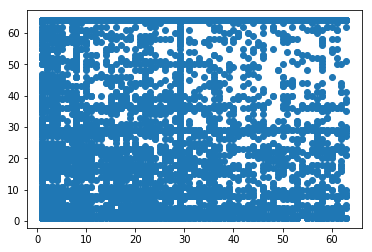

In [149]:
plt.scatter(surv_true[surv_true != 64], surv_pred[surv_true != 64]) # 예측을 굉장히 못한 것을 확인할 수 있다.

In [83]:
y_true.to_csv('true.csv', index=False)
y_pred.to_csv('predict.csv', index=False)

In [94]:
score = score_function('predict.csv', 'train_label.csv')

2072.6570990180185


In [95]:
from os import listdir
li1, li2 = listdir('./test1/'), listdir('./test2/')

import sys
mod = sys.modules[__name__]
for name1, name2 in zip(li1, li2):
    setattr(mod, name1.split('.')[0], pd.read_csv('./test1/' + name1))
    setattr(mod, name2.split('.')[0], pd.read_csv('./test2/' + name2))

In [96]:
test1_activity.shape, test1_combat.shape, test1_pledge.shape, test1_trade.shape, test1_payment.shape

((709928, 17), (696577, 13), (459923, 15), (735652, 11), (24829, 3))

In [97]:
def preprocess1(activity):

    df = activity[
            [col for col in activity.columns if col not in ['server',  'char_id']]
        ].groupby(['day', 'acc_id']).sum().reset_index()

    df_grouped = df.groupby('day')
    p = df_grouped.get_group(1)
    for i in range(2, 29):
        p = pd.merge(p, df_grouped.get_group(i), on='acc_id', how='outer',
                     suffixes=('_'+str(i-1), '_'+str(i)))
    p = p[[col for col in p.columns if ('day' not in col) & ('char' not in col)]]
    p = p.fillna(0).set_index('acc_id')

    playtime_daily = activity.groupby(['acc_id', 'day'])['playtime'].sum().unstack().fillna(0)
    exp_weights = np.sqrt(np.arange(1, 29)) / np.sqrt(np.arange(1, 29)).sum()
    playtime_exp = playtime_daily * exp_weights
    playtime_exp.sum(axis=1).plot.hist(bins=25, grid=True)

    df = p.reset_index()
    p2 = pd.DataFrame(playtime_exp.sum(axis=1), columns=['exp_playtime']).reset_index()
    df = pd.merge(df, p2, on='acc_id')

    d = pd.DataFrame(list(set([(i, j) for i,j in activity[['day', 'acc_id']].values])), columns=['day', 'acc_id'])
    df = pd.merge(df, d.groupby('acc_id').count().reset_index(), on='acc_id')

    train_act_time = activity[['acc_id', 'day', 'playtime', 'fishing', 'private_shop']]
    train_act_time = train_act_time.groupby(['acc_id', 'day']).sum()
    train_act_time['resttime'] = train_act_time['fishing'] + train_act_time['private_shop']
    train_act_time['tr_play'] = (train_act_time['playtime'] - train_act_time['resttime']) / train_act_time['playtime']
    train_act_time['tr_rest'] = train_act_time['resttime'] / train_act_time['playtime']
    rest = train_act_time['tr_rest'].unstack().fillna(1)
    play = train_act_time['tr_play'].unstack().fillna(0)

    rest.columns = ['rest_'+str(i) for i in range(1, 29)]
    play.columns = ['play_'+str(i) for i in range(1, 29)]

    exp_weights = np.sqrt(np.arange(1, 29)) / np.sqrt(np.arange(1, 29)).sum()
    rest['exp_rest'] = (rest * exp_weights).sum(axis=1)
    play['exp_play'] = (play * exp_weights).sum(axis=1)

    df = pd.merge(df, rest.reset_index(), on='acc_id')
    df = pd.merge(df, play.reset_index(), on='acc_id')
    return df

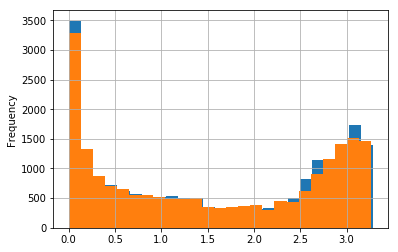

In [101]:
df1 = preprocess1(test1_activity)
df2 = preprocess1(test2_activity)

In [132]:
test1 = df1.set_index('acc_id')
test2 = df2.set_index('acc_id')

In [133]:
surv_pred1 = model1a.predict(xgb.DMatrix(test1)).argmax(axis=1) + 1
amount_pred1 = model2.predict(xgb.DMatrix(test1))

surv_pred2 = model1a.predict(xgb.DMatrix(test2)).argmax(axis=1) + 1
amount_pred2 = model2.predict(xgb.DMatrix(test2))

KeyboardInterrupt: 

In [110]:
y_pred1 = pd.DataFrame(np.concatenate((
                np.array(test1.index).reshape(-1, 1), 
                surv_pred1.reshape(-1, 1), 
                amount_pred1.reshape(-1, 1)), axis=1),
             columns=['acc_id', 'survival_time', 'amount_spent'])

y_pred2 = pd.DataFrame(np.concatenate((
                np.array(test2.index).reshape(-1, 1), 
                surv_pred2.reshape(-1, 1), 
                amount_pred2.reshape(-1, 1)), axis=1),
             columns=['acc_id', 'survival_time', 'amount_spent'])

In [119]:
y_pred1['amount_spent'] = np.where(y_pred1['amount_spent'] < 0, 0, y_pred1['amount_spent'])
y_pred2['amount_spent'] = np.where(y_pred2['amount_spent'] < 0, 0, y_pred2['amount_spent'])

In [121]:
y_pred1.to_csv('test1_predict.csv', index=False, encoding='utf-8')
y_pred2.to_csv('test2_predict.csv', index=False, encoding='utf-8')